In [ ]:
import sys
import os

# Add the path to the directory containing data_loader.py
sys.path.append('/content/drive/MyDrive/u2net')

import time
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import numpy as np
import glob
import os


from data_loader import Rescale
from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET
from model import U2NETP
import gc

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tapakah68/supervisely-filtered-segmentation-person-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.31G/4.31G [03:18<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/versions/3


In [ ]:
import shutil

# Replace this with the path to your dataset directory
dataset_path = path  # Or wherever the dataset is stored

# Define the destination folder in Google Drive
drive_path = "/content/drive/My Drive/datasets/Human-Segmentation-Dataset/"

# Move dataset folder to Google Drive
shutil.move(dataset_path, drive_path)

print(f"Dataset saved to: {drive_path}")

Dataset saved to: /content/drive/My Drive/datasets/Human-Segmentation-Dataset/


In [ ]:
#import shutil
#
#shutil.rmtree('/content/drive/MyDrive/u2net/save_models/u2netp', ignore_errors=True)

In [ ]:
drive_path = "/content/drive/My Drive/datasets/Human-Segmentation-Dataset/"
data_path  = '/content/drive/MyDrive/datasets/Human-Segmentation-Dataset/df.csv'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,collage/ds10_pexels-photo-687782.jpg
1,1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,collage/ds10_pexels-photo-835971.jpg
2,2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,collage/ds10_pexels-photo-850708.jpg
3,3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,collage/ds10_pexels-photo-864937.jpg
4,4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,collage/ds10_pexels-photo-865908.jpg


### define loss function

In [ ]:
bce_loss = nn.BCELoss(reduction='mean')

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v)
	loss1 = bce_loss(d1,labels_v)
	loss2 = bce_loss(d2,labels_v)
	loss3 = bce_loss(d3,labels_v)
	loss4 = bce_loss(d4,labels_v)
	loss5 = bce_loss(d5,labels_v)
	loss6 = bce_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

### load data

In [ ]:
model_name = 'u2netp'

data_dir = ('/content/drive/MyDrive/datasets/Human-Segmentation-Dataset/supervisely_person_clean_2667_img' + os.sep)
tra_image_dir = os.path.join('supervisely_person_clean_2667_img', 'images' + os.sep)
tra_label_dir = os.path.join( 'supervisely_person_clean_2667_img', 'masks' + os.sep)

image_ext = '.png'
label_ext = '.png'

model_dir = os.path.join(os.getcwd(), 'saved_models', model_name + os.sep)

epoch_num = 100
batch_size_train = 16
batch_size_val = 16
train_num = 0
val_num = 0

tra_img_name_list = glob.glob(data_dir + tra_image_dir + '*' + image_ext)
#tra_img_name_list = images

tra_lbl_name_list = []
for img_path in tra_img_name_list:
    img_name = img_path.split(os.sep)[-1]

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

print("---")
print("train images: ", len(tra_img_name_list))
print("train labels: ", len(tra_lbl_name_list))
print("---")

train_num = len(tra_img_name_list)

salobj_dataset = SalObjDataset(
    img_name_list=tra_img_name_list,
    lbl_name_list=tra_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(160),
        RandomCrop(144),
        ToTensorLab(flag=0)]))
salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

---
train images:  2667
train labels:  2667
---


### show images

Batch number: 0
Images shape: torch.Size([16, 3, 144, 144])
Labels shape: torch.Size([16, 1, 144, 144])


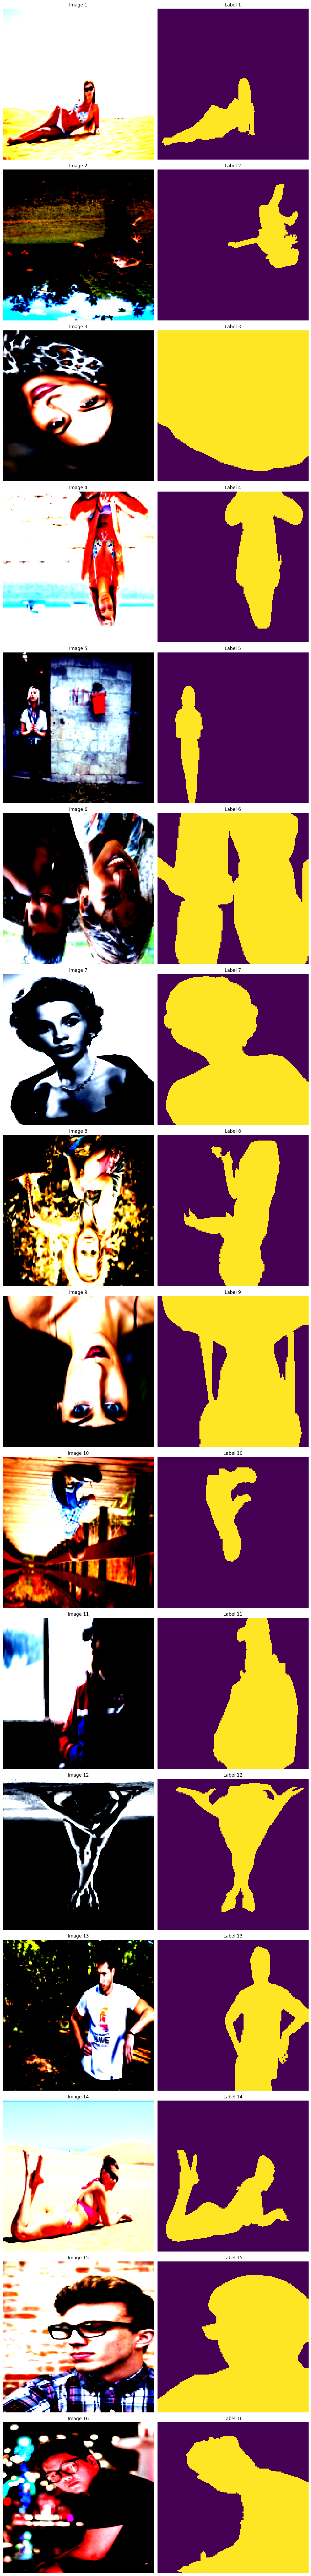

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up an empty list for data (this isn't actually used, so you can remove it)
# data = []

l = []

# Get a batch of data from the dataloader
for i, data_batch in enumerate(salobj_dataloader):
    if i == 0:  # Get only the first batch for inspection
        images, labels = data_batch['image'], data_batch['label']

        print("Batch number:", i)
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)

        # Plotting the first image and its corresponding label
        fig, axes = plt.subplots(batch_size_train, 2, figsize=(12, 6 * batch_size_train))

        for j in range(batch_size_train):
            # Plot image
            axes[j, 0].imshow(images[j].permute(1, 2, 0).numpy())  # Convert to HWC format
            axes[j, 0].set_title(f"Image {j+1}")
            axes[j, 0].axis("off")

            # Plot label
            axes[j, 1].imshow(labels[j].permute(1, 2, 0).numpy())  # Convert to HWC format
            axes[j, 1].set_title(f"Label {j+1}")
            axes[j, 1].axis("off")

            l=labels[j]

        plt.tight_layout()  # Ensure there's no overlap between images
        plt.show()

    if i >= 1:  # Only fetch the first batch
        break


In [ ]:
len(l)

# if the len(l) == 1 then the labels is a binary with chanel 1

1

### define model

In [ ]:
model_name = 'u2netp'

if(model_name=='u2net'):
    net = U2NET(3, 1)
elif(model_name=='u2netp'):
    net = U2NETP(3,1)

if torch.cuda.is_available() and False:
    net.cuda()

### define optimizer

In [ ]:
print("---define optimizer...")
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

---define optimizer...


### train part

In [ ]:
if __name__ == '__main__':
    model_name = 'u2netp'

    # data_dir = os.path.join(os.getcwd(), 'DUTS' + os.sep)
    # tra_image_dir = os.path.join( 'DUTS-TR', 'DUTS-TR-Image' + os.sep)
    # tra_label_dir = os.path.join( 'DUTS-TR', 'DUTS-TR-Mask' + os.sep)

    data_dir = ('/content/drive/MyDrive/datasets/Human-Segmentation-Dataset/supervisely_person_clean_2667_img' + os.sep)
    tra_image_dir = os.path.join('supervisely_person_clean_2667_img', 'images' + os.sep)
    tra_label_dir = os.path.join( 'supervisely_person_clean_2667_img', 'masks' + os.sep)

    image_ext = '.png'
    label_ext = '.png'

    model_dir = os.path.join('/content/drive/MyDrive/u2net/save_models', model_name + os.sep)

    epoch_num = 100
    batch_size_train = 16
    batch_size_val = 16
    train_num = 0
    val_num = 0

    tra_img_name_list = glob.glob(data_dir + tra_image_dir + '*' + image_ext)
     #tra_img_name_list = images

    tra_lbl_name_list = []
    for img_path in tra_img_name_list:
        img_name = img_path.split(os.sep)[-1]

        aaa = img_name.split(".")
        bbb = aaa[0:-1]
        imidx = bbb[0]
        for i in range(1,len(bbb)):
            imidx = imidx + "." + bbb[i]

        tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

    print("---")
    print("train images: ", len(tra_img_name_list))
    print("train labels: ", len(tra_lbl_name_list))
    print("---")

    train_num = len(tra_img_name_list)

    salobj_dataset = SalObjDataset(
        img_name_list=tra_img_name_list,
        lbl_name_list=tra_lbl_name_list,
        transform=transforms.Compose([
            RescaleT(160),
            RandomCrop(144),
            ToTensorLab(flag=0)]))
    salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

    # ------- 3. define model --------
    # define the net
    if(model_name=='u2net'):
        net = U2NET(3, 1)
    elif(model_name=='u2netp'):
        net = U2NETP(3,1)

    if torch.cuda.is_available() and False:
        net.cuda()


    # dml = torch_directml.device()

    # net.to(dml)
    # ------- 4. define optimizer --------
    print("---define optimizer...")
    optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # ------- 5. training process --------
    print("---start training...")
    ite_num = 0
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    save_frq = 10 # save the model every 2000 iterations


    tic = time.time()
    for epoch in range(0, epoch_num):
        net.train()

        for i, data in enumerate(salobj_dataloader):
            ite_num = ite_num + 1
            ite_num4val = ite_num4val + 1


            toc = time.time()

            print("time " + str(toc- tic))

            tic= time.time()
            inputs, labels = data['image'], data['label']

            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)

            # inputs = inputs.float()
            # labels = labels.float()

            # inputs_v, labels_v = Variable(inputs.to(dml), requires_grad=False), Variable(labels.to(dml), requires_grad=False)
            # wrap them in Variable
            if torch.cuda.is_available() and False:
                inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                            requires_grad=False)
            else:
                inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

            # y zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            d0, d1, d2, d3, d4, d5, d6 = net(inputs_v)
            loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

            loss.backward()
            optimizer.step()

            # # print statistics
            running_loss += loss.data.item()
            running_tar_loss += loss2.data.item()

            # del temporary outputs and loss
            del d0, d1, d2, d3, d4, d5, d6, loss2, loss
            gc.collect()
            print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
            epoch + 1, epoch_num, (i + 1) * batch_size_train, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))

            if ite_num % save_frq == 0:

                torch.save(net.state_dict(), model_dir + model_name+"_bce_itr_%d_train_%3f_tar_%3f.pth" % (ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
                running_loss = 0.0
                running_tar_loss = 0.0
                net.train()  # resume train
                ite_num4val = 0

---
train images:  2667
train labels:  2667
---
---define optimizer...
---start training...
time 13.18717336654663


/content/drive/MyDrive/u2net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


l0: 0.733780, l1: 0.678345, l2: 0.708134, l3: 0.769491, l4: 0.778865, l5: 0.660022, l6: 0.699115

[epoch:   1/100, batch:    16/ 2667, ite: 1] train loss: 5.027752, tar: 0.733780 
time 59.972283124923706
l0: 0.755550, l1: 0.691020, l2: 0.678074, l3: 0.731125, l4: 0.719923, l5: 0.676926, l6: 0.763652

[epoch:   1/100, batch:    32/ 2667, ite: 2] train loss: 5.022011, tar: 0.744665 
time 14.788608074188232
l0: 0.740267, l1: 0.644605, l2: 0.761152, l3: 0.826177, l4: 0.845963, l5: 0.642598, l6: 0.609236

[epoch:   1/100, batch:    48/ 2667, ite: 3] train loss: 5.038007, tar: 0.743199 
time 13.21358609199524
l0: 0.722821, l1: 0.654676, l2: 0.736252, l3: 0.811423, l4: 0.823278, l5: 0.653513, l6: 0.665836

[epoch:   1/100, batch:    64/ 2667, ite: 4] train loss: 5.045455, tar: 0.738105 
time 18.89759612083435
l0: 0.742743, l1: 0.679112, l2: 0.708398, l3: 0.747945, l4: 0.739199, l5: 0.685594, l6: 0.723071

[epoch:   1/100, batch:    80/ 2667, ite: 5] train loss: 5.041577, tar: 0.739032 
time 1

KeyboardInterrupt: 

In [ ]:
model_path = '/content/drive/MyDrive/u2net/save_models/u2netp/u2netp_bce_itr_990_train_2.887504_tar_0.397320.pth'

net.load_state_dict(torch.load(model_path, map_location='cuda'))

net.eval()

<ipython-input-16-814e8a43266e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location='cuda'))


U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(2, 2, kernel_siz

Batch number: 0
Images shape: torch.Size([16, 3, 144, 144])
Labels shape: torch.Size([16, 1, 144, 144])


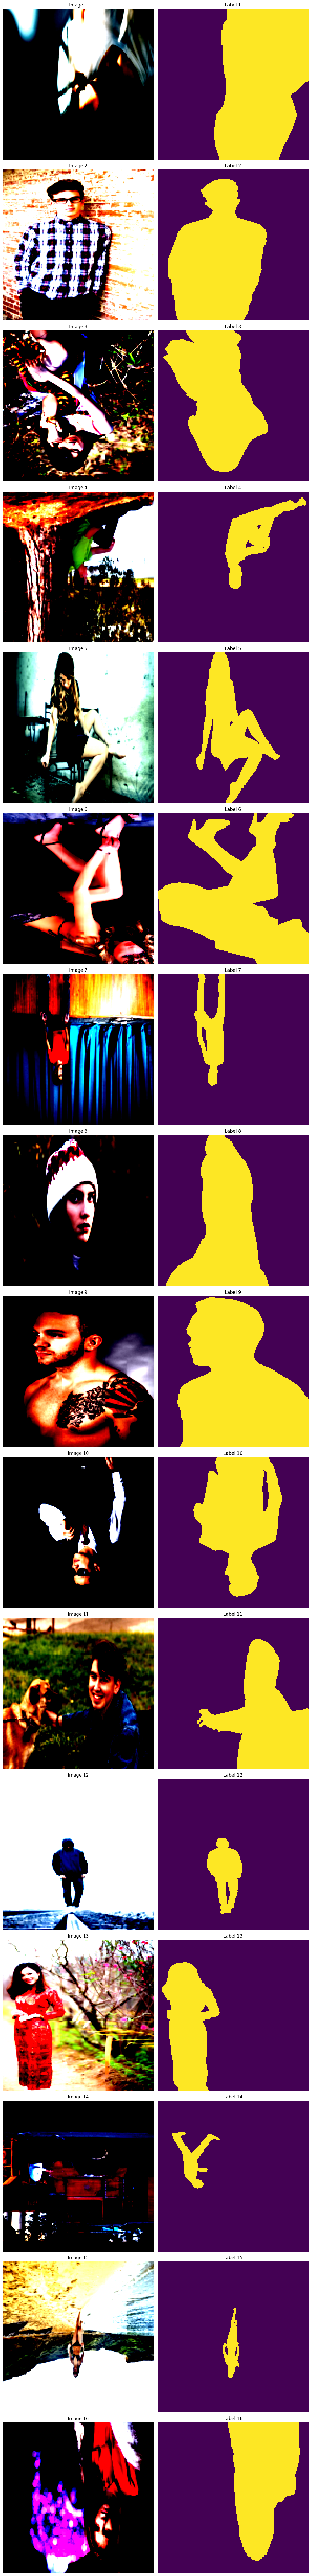

In [ ]:
image_predict = []

for i, data_batch in enumerate(salobj_dataloader):
    if i == 0:  # Get only the first batch for inspection
        images, labels = data_batch['image'], data_batch['label']

        print("Batch number:", i)
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)

        # Plotting the first image and its corresponding label
        fig, axes = plt.subplots(batch_size_train, 2, figsize=(12, 6 * batch_size_train))

        for j in range(batch_size_train):
            # Plot image
            axes[j, 0].imshow(images[j].permute(1, 2, 0).numpy())  # Convert to HWC format
            axes[j, 0].set_title(f"Image {j+1}")
            axes[j, 0].axis("off")

            # Plot label
            axes[j, 1].imshow(labels[j].permute(1, 2, 0).numpy())  # Convert to HWC format
            axes[j, 1].set_title(f"Label {j+1}")
            axes[j, 1].axis("off")

        image_predict = images[1]

        plt.tight_layout()  # Ensure there's no overlap between images
        plt.show()

    if i >= 1:  # Only fetch the first batch
        break


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure the model is in evaluation mode
net.eval()

# 2. Check if GPU is available (optional)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

# 3. Load and prepare the image
image_path = '/content/drive/MyDrive/images.jpg'  # Change this to your image path
image = Image.open(image_path).convert('RGB')

# Resize and normalize the image for U²-Net
transform = transforms.Compose([
    transforms.Resize((320, 320)),       # U²-Net input size
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize([0.5], [0.5])   # Normalize to [-1, 1]
])

input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# 4. Make prediction
with torch.no_grad():
    output = net(input_tensor)  # Run the model

# 5. Get the mask (first output is the main mask)
mask = output[0].squeeze().cpu().numpy()

# Normalize mask to 0-255 (for saving or viewing)
mask = (mask - mask.min()) / (mask.max() - mask.min()) * 255
mask = mask.astype(np.uint8)

# 6. Save the predicted mask
mask_image = Image.fromarray(mask)

print("Prediction complete! Mask saved.")


Prediction complete! Mask saved.


/content/drive/MyDrive/u2net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


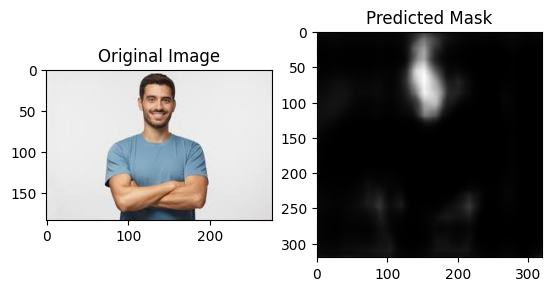

In [ ]:
# Show the original image and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [ ]:
type(mask), type(image)

(numpy.ndarray, PIL.Image.Image)

In [ ]:
image = np.array(image)
type(image)

numpy.ndarray

In [ ]:
len(mask), len(image)

(320, 183)

In [ ]:
image.shape

(183, 275, 3)

In [ ]:
mask.max(), mask.min()

(255, 0)

Before normalization:  (320, 320, 3) -0.99215686 1.0
After normalization:  (320, 320, 3) 0 255


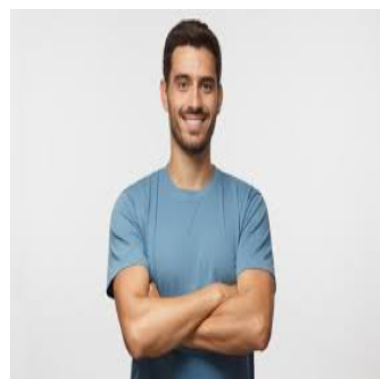

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the first image from the batch (shape: (3, H, W))
image = input_tensor[0]

# Ensure the shape is (H, W, 3) for RGB images
image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)

# Debug: Check statistics before normalization
print("Before normalization: ", image.shape, image.min(), image.max())

# Avoid division by zero and normalize only if the range is valid
if image.max() > image.min():
    image = (image - image.min()) / (image.max() - image.min()) * 255

# Ensure proper data type for visualization
image = image.astype(np.uint8)

# Debug: Check statistics after normalization
print("After normalization: ", image.shape, image.min(), image.max())

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
binary_mask = np.where(mask >= 128, 255, 0).astype(np.uint8)
masked = cv2.bitwise_and(image, image, mask=binary_mask)

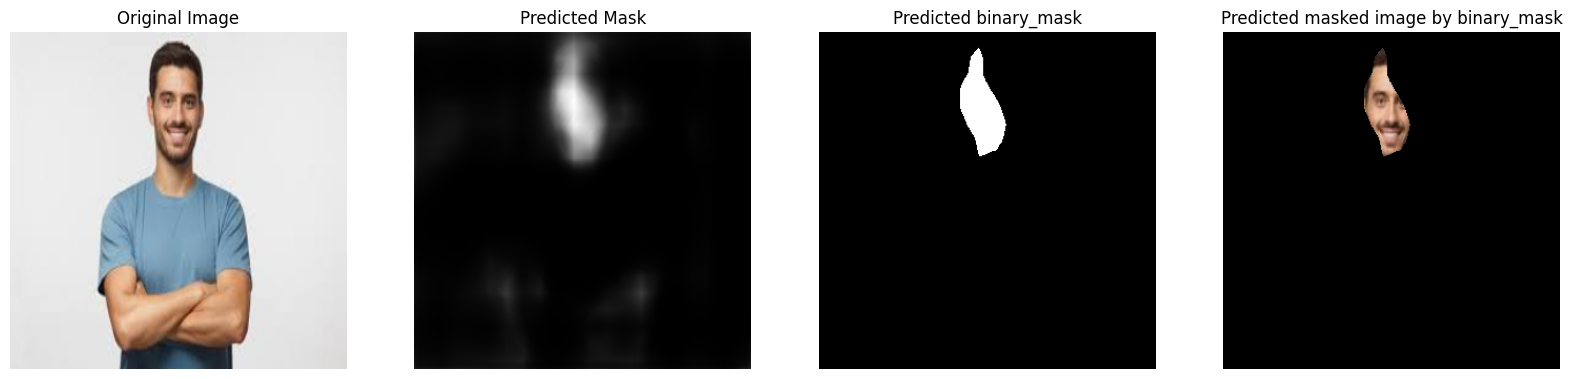

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted binary_mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(masked)
plt.title("Predicted masked image by binary_mask")
plt.axis('off')

plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
# masked_for_model = np.stack((masked,) * 3, axis=-1) # Stack grayscale to RGB
masked_for_model = tf.image.resize(image, (320, 320)) # Resize to 320x320
masked_for_model = tf.expand_dims(masked_for_model, axis=0)  # Add batch dimension

In [ ]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(320,320,3),
    include_top=False,
    weights='imagenet',
    pooling='max',
)

for layers in pre_trained_model.layers[:-3]:
    layers.trainable=False

num_class = 45

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(), # Flatten the output from the pre-trained model
    tf.keras.layers.Dense(num_class, activation='softmax') # Add a Dense layer for classification with 45 units and softmax activation
])


<ipython-input-70-f7e4f7012975>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
predictions  = model.predict(masked_for_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
len(predictions)

1

In [ ]:
len(predictions[0])

45

In [ ]:
predictions[0]

array([4.7011617e-05, 3.0158273e-07, 2.8768930e-04, 2.7296619e-04,
       1.2501367e-04, 1.3094489e-04, 2.1868065e-02, 9.2509115e-05,
       1.9569933e-02, 4.2514253e-05, 5.8105827e-05, 1.9205697e-06,
       2.3862849e-05, 3.7691323e-04, 3.1961406e-06, 1.9933870e-04,
       3.0638665e-04, 1.3798864e-04, 2.5276793e-03, 1.0414105e-05,
       3.0945444e-07, 8.2610280e-04, 7.3731661e-02, 2.2642597e-08,
       4.0650818e-08, 2.6666541e-07, 5.5534248e-03, 3.4159565e-04,
       6.3710381e-06, 1.9869526e-08, 2.0546880e-02, 8.3504599e-01,
       4.2534694e-03, 3.1025289e-04, 2.3408320e-04, 1.1492232e-08,
       4.9760878e-05, 2.0055879e-07, 3.1647225e-05, 5.0965464e-05,
       1.5099997e-07, 3.1105636e-05, 1.9481362e-05, 4.8336148e-04,
       1.2400154e-02], dtype=float32)

In [ ]:
import zipfile

# Path to your zip file
zip_file_path = '/content/drive/MyDrive/Abfa.zip'
# Directory where you want to extract the contents
extract_to_directory = '/content/drive/MyDrive/DATA/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("File extracted successfully!")

File extracted successfully!
